<!-- dom:TITLE: Week 39: Optimization and  Gradient Methods -->
# Week 39: Optimization and  Gradient Methods
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Sep 28, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license



## Plan for week 39

* Thursday: Repetition of Logistic regression equations and classification problems and discussion of Gradient methods. Discussion of project 1 and examples on how to implement Logistic Regression

* Friday: Stochastic Gradient descent with examples and automatic differentiation

* Reading recommendations:

See [lecture notes for week 39](https://compphysics.github.io/MachineLearning/doc/web/course.html).
For a good discussion on gradient methods, see Goodfellow et al section 4.3-4.5 and chapter 8. We will come back to the latter chapter in our discussion of Neural networks as well.

## Thursday September 30

[Overview Video, why do we care about gradient methods?](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h20/forelesningsvideoer/OverarchingAimsWeek39.mp4?vrtx=view-as-webpage)


## Searching for Optimal Regularization Parameters $\lambda$

In project 1, when using Ridge and Lasso regression, we end up
searching for the optimal parameter $\lambda$ which minimizes our
selected scores (MSE or $R2$ values for example). The brute force
approach, as discussed in the code here for Ridge regression, consists
in evaluating the MSE as function of different $\lambda$ values.
Based on these calculations, one tries then to determine the value of the hyperparameter $\lambda$
which results in optimal scores (for example the smallest MSE or an $R2=1$).

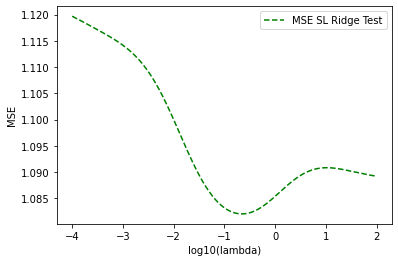

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 500
MSERidgePredict = np.zeros(nlambdas)
lambdas = np.logspace(-4, 2, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    RegRidge = linear_model.Ridge(lmb)
    RegRidge.fit(X_train,y_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSERidgePredict, 'g--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Here we have performed a rather data greedy calculation as function of the regularization parameter $\lambda$. There is no resampling here. The latter can easily be added by employing the function **RidgeCV** instead of just calling the **Ridge** function. For **RidgeCV** we need to passe the array of $\lambda$ values.
By inspecting the figure we can in turn determine which is the optimal regularization parameter.
This becomes however less functional in the long run. 


## Grid Search


An alternative is to use the so-called grid search functionality
included with the library **Scikit-Learn**, as demonstrated for the same
example here.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas)
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = GridSearchCV(estimator=model, param_grid=dict(alpha=lambdas))
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])})
Best estimated lambda-value: 100.0
MSE score: 1.0892144853354966
R2 score: -0.0038332550504751595


*By default the grid search function includes cross validation with five folds.* 

The [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) contains more information on how to set the different parameters.

## Randomized Grid Search

An alternative to the above manual grid set up, is to use a random
search where the parameters are tuned from a random distribution
(uniform below) for a fixed number of iterations. A model is
constructed and evaluated for each combination of chosen parameters.
We repeat the previous example but **now with a random search**.

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as randuniform
from sklearn.model_selection import RandomizedSearchCV


def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {'alpha': randuniform()} #######################################
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

RandomizedSearchCV(estimator=Ridge(), n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7f67f9b370>})
Best estimated lambda-value: 0.9849967686928113
MSE score: 1.0853136633465326
R2 score: -0.0002382102844775691


## Optimization, the central part of any Machine Learning algortithm

Almost every problem in machine learning and data science starts with
a dataset $X$, a model $g(\beta)$, which is a function of the
parameters $\beta$ and a cost function $C(X, g(\beta))$ that allows
us to judge how well the model $g(\beta)$ explains the observations
$X$. The model is fit by finding the values of $\beta$ that minimize
the cost function. Ideally we would be able to solve for $\beta$
analytically, however this is not possible in general and we must use
some approximative/numerical method to compute the minimum.


## Revisiting our Logistic Regression case

In our discussion on Logistic Regression we studied the 
case of
two classes, with $y_i$ either
$0$ or $1$. Furthermore we assumed also that we have only two
parameters $\beta$ in our fitting, that is we
defined probabilities

$$
\begin{align*}
p(y_i=1|x_i,\boldsymbol{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\boldsymbol{\beta}) &= 1 - p(y_i=1|x_i,\boldsymbol{\beta}),
\end{align*}
$$

where $\boldsymbol{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

## The equations to solve

Our compact equations used a definition of a vector $\boldsymbol{y}$ with $n$
elements $y_i$, an $n\times p$ matrix $\boldsymbol{X}$ which contains the
$x_i$ values and a vector $\boldsymbol{p}$ of fitted probabilities
$p(y_i\vert x_i,\boldsymbol{\beta})$. We rewrote in a more compact form
the first derivative of the cost function as

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = -\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{p}\right).
$$

If we in addition define a diagonal matrix $\boldsymbol{W}$ with elements 
$p(y_i\vert x_i,\boldsymbol{\beta})(1-p(y_i\vert x_i,\boldsymbol{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T} = \boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X}.
$$

This defines what is called  the Hessian matrix.

## Solving using Newton-Raphson's method

If we can set up these equations, Newton-Raphson's iterative method is normally the method of choice. It requires however that we can compute in an efficient way the  matrices that define the first and second derivatives. 

Our iterative scheme is then given by

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T}\right)^{-1}_{\boldsymbol{\beta}^{\mathrm{old}}}\times \left(\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}}\right)_{\boldsymbol{\beta}^{\mathrm{old}}},
$$

or in matrix form as

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X} \right)^{-1}\times \left(-\boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{p}) \right)_{\boldsymbol{\beta}^{\mathrm{old}}}.
$$

The right-hand side is computed with the old values of $\beta$. 

If we can compute these matrices, in particular the Hessian, the above is often the easiest method to implement. 


## Brief reminder on Newton-Raphson's method

Let us quickly remind ourselves how we derive the above method.

Perhaps the most celebrated of all one-dimensional root-finding
routines is Newton's method, also called the Newton-Raphson
method. This method  requires the evaluation of both the
function $f$ and its derivative $f'$ at arbitrary points. 
If you can only calculate the derivative
numerically and/or your function is not of the smooth type, we
normally discourage the use of this method.

## The equations

The Newton-Raphson formula consists geometrically of extending the
tangent line at a current point until it crosses zero, then setting
the next guess to the abscissa of that zero-crossing.  The mathematics
behind this method is rather simple. Employing a Taylor expansion for
$x$ sufficiently close to the solution $s$, we have

<!-- Equation labels as ordinary links -->
<div id="eq:taylornr"></div>

$$
f(s)=0=f(x)+(s-x)f'(x)+\frac{(s-x)^2}{2}f''(x) +\dots.
    \label{eq:taylornr} \tag{1}
$$

For small enough values of the function and for well-behaved
functions, the terms beyond linear are unimportant, hence we obtain

$$
f(x)+(s-x)f'(x)\approx 0,
$$

yielding

$$
s\approx x-\frac{f(x)}{f'(x)}.
$$

Having in mind an iterative procedure, it is natural to start iterating with

$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}.
$$

## Simple geometric interpretation

The above is Newton-Raphson's method. It has a simple geometric
interpretation, namely $x_{n+1}$ is the point where the tangent from
$(x_n,f(x_n))$ crosses the $x$-axis.  Close to the solution,
Newton-Raphson converges fast to the desired result. However, if we
are far from a root, where the higher-order terms in the series are
important, the Newton-Raphson formula can give grossly inaccurate
results. For instance, the initial guess for the root might be so far
from the true root as to let the search interval include a local
maximum or minimum of the function.  If an iteration places a trial
guess near such a local extremum, so that the first derivative nearly
vanishes, then Newton-Raphson may fail totally


## Extending to more than one variable

Newton's method can be generalized to systems of several non-linear equations
and variables. Consider the case with two equations

$$
\begin{array}{cc} f_1(x_1,x_2) &=0\\
                     f_2(x_1,x_2) &=0,\end{array}
$$

which we Taylor expand to obtain

$$
\begin{array}{cc} 0=f_1(x_1+h_1,x_2+h_2)=&f_1(x_1,x_2)+h_1
                     \partial f_1/\partial x_1+h_2
                     \partial f_1/\partial x_2+\dots\\
                     0=f_2(x_1+h_1,x_2+h_2)=&f_2(x_1,x_2)+h_1
                     \partial f_2/\partial x_1+h_2
                     \partial f_2/\partial x_2+\dots
                       \end{array}.
$$

Defining the Jacobian matrix ${\bf \boldsymbol{J}}$ we have

$$
{\bf \boldsymbol{J}}=\left( \begin{array}{cc}
                         \partial f_1/\partial x_1  & \partial f_1/\partial x_2 \\
                          \partial f_2/\partial x_1     &\partial f_2/\partial x_2
             \end{array} \right),
$$

we can rephrase Newton's method as

$$
\left(\begin{array}{c} x_1^{n+1} \\ x_2^{n+1} \end{array} \right)=
\left(\begin{array}{c} x_1^{n} \\ x_2^{n} \end{array} \right)+
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right),
$$

where we have defined

$$
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right)=
   -{\bf \boldsymbol{J}}^{-1}
   \left(\begin{array}{c} f_1(x_1^{n},x_2^{n}) \\ f_2(x_1^{n},x_2^{n}) \end{array} \right).
$$

We need thus to compute the inverse of the Jacobian matrix and it
is to understand that difficulties  may
arise in case ${\bf \boldsymbol{J}}$ is nearly singular.

It is rather straightforward to extend the above scheme to systems of
more than two non-linear equations. In our case, the Jacobian matrix is given by the Hessian that represents the second derivative of cost function. 



## Steepest descent

The basic idea of gradient descent is
that a function $F(\mathbf{x})$, 
$\mathbf{x} \equiv (x_1,\cdots,x_n)$, decreases fastest if one goes from $\bf {x}$ in the
direction of the negative gradient $-\nabla F(\mathbf{x})$.

It can be shown that if

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

with $\gamma_k > 0$.

For $\gamma_k$ small enough, then $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$. This means that for a sufficiently small $\gamma_k$
we are always moving towards smaller function values, i.e a minimum.

<!-- !split  -->
## More on Steepest descent

The previous observation is the basis of the method of steepest
descent, which is also referred to as just gradient descent (GD). One
starts with an initial guess $\mathbf{x}_0$ for a minimum of $F$ and
computes new approximations according to

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k), \ \ k \geq 0.
$$

The parameter $\gamma_k$ is often referred to as the step length or
the learning rate within the context of Machine Learning.

<!-- !split  -->
## The ideal

Ideally the sequence $\{\mathbf{x}_k \}_{k=0}$ converges to a global
minimum of the function $F$. In general we do not know if we are in a
global or local minimum. In the special case when $F$ is a convex
function, all local minima are also global minima, so in this case
gradient descent can converge to the global solution. The advantage of
this scheme is that it is conceptually simple and straightforward to
implement. However the method in this form has some severe
limitations:

In machine learing we are often faced with non-convex high dimensional
cost functions with many local minima. Since GD is deterministic we
will get stuck in a local minimum, if the method converges, unless we
have a very good intial guess. This also implies that the scheme is
sensitive to the chosen initial condition.

Note that the gradient is a function of $\mathbf{x} =
(x_1,\cdots,x_n)$ which makes it expensive to compute numerically.


<!-- !split  -->
## The sensitiveness of the gradient descent

The gradient descent method 
is sensitive to the choice of learning rate $\gamma_k$. This is due
to the fact that we are only guaranteed that $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ for sufficiently small $\gamma_k$. The problem is to
determine an optimal learning rate. If the learning rate is chosen too
small the method will take a long time to converge and if it is too
large we can experience erratic behavior.

Many of these shortcomings can be alleviated by introducing
randomness. One such method is that of Stochastic Gradient Descent
(SGD), see below.


<!-- !split  -->
## Convex functions

Ideally we want our cost/loss function to be convex(concave).

First we give the definition of a convex set: A set $C$ in
$\mathbb{R}^n$ is said to be convex if, for all $x$ and $y$ in $C$ and
all $t \in (0,1)$ , the point $(1 − t)x + ty$ also belongs to
C. Geometrically this means that every point on the line segment
connecting $x$ and $y$ is in $C$ as discussed below.

The convex subsets of $\mathbb{R}$ are the intervals of
$\mathbb{R}$. Examples of convex sets of $\mathbb{R}^2$ are the
regular polygons (triangles, rectangles, pentagons, etc...).

## Convex function

**Convex function**: Let $X \subset \mathbb{R}^n$ be a convex set. Assume that the function $f: X \rightarrow \mathbb{R}$ is continuous, then $f$ is said to be convex if $$f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2) $$ for all $x_1, x_2 \in X$ and for all $t \in [0,1]$. If $\leq$ is replaced with a strict inequaltiy in the definition, we demand $x_1 \neq x_2$ and $t\in(0,1)$ then $f$ is said to be strictly convex. For a single variable function, convexity means that if you draw a straight line connecting $f(x_1)$ and $f(x_2)$, the value of the function on the interval $[x_1,x_2]$ is always below the line as illustrated below.

## Conditions on convex functions

In the following we state first and second-order conditions which
ensures convexity of a function $f$. We write $D_f$ to denote the
domain of $f$, i.e the subset of $R^n$ where $f$ is defined. For more
details and proofs we refer to: [S. Boyd and L. Vandenberghe. Convex Optimization. Cambridge University Press](http://stanford.edu/boyd/cvxbook/, 2004).

**First order condition.**

Suppose $f$ is differentiable (i.e $\nabla f(x)$ is well defined for
all $x$ in the domain of $f$). Then $f$ is convex if and only if $D_f$
is a convex set and $$f(y) \geq f(x) + \nabla f(x)^T (y-x) $$ holds
for all $x,y \in D_f$. This condition means that for a convex function
the first order Taylor expansion (right hand side above) at any point
a global under estimator of the function. To convince yourself you can
make a drawing of $f(x) = x^2+1$ and draw the tangent line to $f(x)$ and
note that it is always below the graph.



**Second order condition.**

Assume that $f$ is twice
differentiable, i.e the Hessian matrix exists at each point in
$D_f$. Then $f$ is convex if and only if $D_f$ is a convex set and its
Hessian is positive semi-definite for all $x\in D_f$. For a
single-variable function this reduces to $f''(x) \geq 0$. Geometrically this means that $f$ has nonnegative curvature
everywhere.



This condition is particularly useful since it gives us an procedure for determining if the function under consideration is convex, apart from using the definition.

## More on convex functions

The next result is of great importance to us and the reason why we are
going on about convex functions. In machine learning we frequently
have to minimize a loss/cost function in order to find the best
parameters for the model we are considering. 

Ideally we want the
global minimum (for high-dimensional models it is hard to know
if we have local or global minimum). However, if the cost/loss function
is convex the following result provides invaluable information:

**Any minimum is global for convex functions.**

Consider the problem of finding $x \in \mathbb{R}^n$ such that $f(x)$
is minimal, where $f$ is convex and differentiable. Then, any point
$x^*$ that satisfies $\nabla f(x^*) = 0$ is a global minimum.



This result means that if we know that the cost/loss function is convex and we are able to find a minimum, we are guaranteed that it is a global minimum.

## Some simple problems

1. Show that $f(x)=x^2$ is convex for $x \in \mathbb{R}$ using the definition of convexity. Hint: If you re-write the definition, $f$ is convex if the following holds for all $x,y \in D_f$ and any $\lambda \in [0,1]$ $\lambda f(x)+(1-\lambda)f(y)-f(\lambda x + (1-\lambda) y ) \geq 0$.

2. Using the second order condition show that the following functions are convex on the specified domain.

 * $f(x) = e^x$ is convex for $x \in \mathbb{R}$.

 * $g(x) = -\ln(x)$ is convex for $x \in (0,\infty)$.


3. Let $f(x) = x^2$ and $g(x) = e^x$. Show that $f(g(x))$ and $g(f(x))$ is convex for $x \in \mathbb{R}$. Also show that if $f(x)$ is any convex function than $h(x) = e^{f(x)}$ is convex.

4. A norm is any function that satisfy the following properties

 * $f(\alpha x) = |\alpha| f(x)$ for all $\alpha \in \mathbb{R}$.

 * $f(x+y) \leq f(x) + f(y)$

 * $f(x) \leq 0$ for all $x \in \mathbb{R}^n$ with equality if and only if $x = 0$


Using the definition of convexity, try to show that a function satisfying the properties above is convex (the third condition is not needed to show this).




## Standard steepest descent


Before we proceed, we would like to discuss the approach called the
**standard Steepest descent** (different from the above steepest descent discussion), which again leads to us having to be able
to compute a matrix. It belongs to the class of Conjugate Gradient methods (CG).

[The success of the CG method](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)
for finding solutions of non-linear problems is based on the theory
of conjugate gradients for linear systems of equations. It belongs to
the class of iterative methods for solving problems from linear
algebra of the type

$$
\boldsymbol{A}\boldsymbol{x} = \boldsymbol{b}.
$$

In the iterative process we end up with a problem like

$$
\boldsymbol{r}= \boldsymbol{b}-\boldsymbol{A}\boldsymbol{x},
$$

where $\boldsymbol{r}$ is the so-called residual or error in the iterative process.

When we have found the exact solution, $\boldsymbol{r}=0$.

## Gradient method

The residual is zero when we reach the minimum of the quadratic equation

$$
P(\boldsymbol{x})=\frac{1}{2}\boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x} - \boldsymbol{x}^T\boldsymbol{b},
$$

with the constraint that the matrix $\boldsymbol{A}$ is positive definite and
symmetric.  This defines also the Hessian and we want it to be  positive definite.  


## Steepest descent  method

We denote the initial guess for $\boldsymbol{x}$ as $\boldsymbol{x}_0$. 
We can assume without loss of generality that

$$
\boldsymbol{x}_0=0,
$$

or consider the system

$$
\boldsymbol{A}\boldsymbol{z} = \boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_0,
$$

instead.


## Steepest descent  method
One can show that the solution $\boldsymbol{x}$ is also the unique minimizer of the quadratic form

$$
f(\boldsymbol{x}) = \frac{1}{2}\boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x} - \boldsymbol{x}^T \boldsymbol{x} , \quad \boldsymbol{x}\in\mathbf{R}^n.
$$

This suggests taking the first basis vector $\boldsymbol{r}_1$ (see below for definition) 
to be the gradient of $f$ at $\boldsymbol{x}=\boldsymbol{x}_0$, 
which equals

$$
\boldsymbol{A}\boldsymbol{x}_0-\boldsymbol{b},
$$

and 
$\boldsymbol{x}_0=0$ it is equal $-\boldsymbol{b}$.



## Final expressions
We can compute the residual iteratively as

$$
\boldsymbol{r}_{k+1}=\boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_{k+1},
$$

which equals

$$
\boldsymbol{b}-\boldsymbol{A}(\boldsymbol{x}_k+\alpha_k\boldsymbol{r}_k),
$$

or

$$
(\boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_k)-\alpha_k\boldsymbol{A}\boldsymbol{r}_k,
$$

which gives

$$
\alpha_k = \frac{\boldsymbol{r}_k^T\boldsymbol{r}_k}{\boldsymbol{r}_k^T\boldsymbol{A}\boldsymbol{r}_k}
$$

leading to the iterative scheme

$$
\boldsymbol{x}_{k+1}=\boldsymbol{x}_k-\alpha_k\boldsymbol{r}_{k},
$$

## Steepest descent example

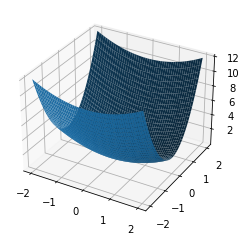

In [12]:
import numpy as np
import numpy.linalg as la

import scipy.optimize as sopt

import matplotlib.pyplot as pt
from mpl_toolkits.mplot3d import axes3d

def f(x):
    return 0.5*x[0]**2 + 2.5*x[1]**2

def df(x):
    return np.array([x[0], 5*x[1]])

fig = pt.figure()
ax = fig.gca(projection="3d")

xmesh, ymesh = np.mgrid[-2:2:50j,-2:2:50j]
fmesh = f(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, fmesh)

And then as countor plot

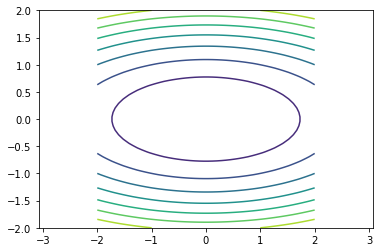

In [13]:
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh)
guesses = [np.array([2, 2./5])]

Find guesses

In [14]:
x = guesses[-1]
s = -df(x)

Run it!

In [15]:
def f1d(alpha):
    return f(x + alpha*s)

alpha_opt = sopt.golden(f1d)
next_guess = x + alpha_opt * s
guesses.append(next_guess)
print(next_guess)

[ 1.33333333 -0.26666667]


What happened?

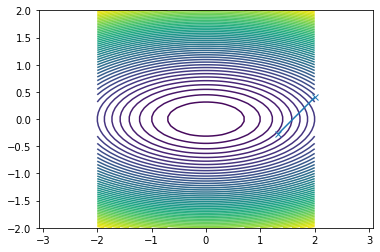

In [16]:
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh, 50)
it_array = np.array(guesses)
pt.plot(it_array.T[0], it_array.T[1], "x-")

## Conjugate gradient method
In the CG method we define so-called conjugate directions and two vectors 
$\boldsymbol{s}$ and $\boldsymbol{t}$
are said to be
conjugate if

$$
\boldsymbol{s}^T\boldsymbol{A}\boldsymbol{t}= 0.
$$

The philosophy of the CG method is to perform searches in various conjugate directions
of our vectors $\boldsymbol{x}_i$ obeying the above criterion, namely

$$
\boldsymbol{x}_i^T\boldsymbol{A}\boldsymbol{x}_j= 0.
$$

Two vectors are conjugate if they are orthogonal with respect to 
this inner product. Being conjugate is a symmetric relation: if $\boldsymbol{s}$ is conjugate to $\boldsymbol{t}$, then $\boldsymbol{t}$ is conjugate to $\boldsymbol{s}$.



## Conjugate gradient method
An example is given by the eigenvectors of the matrix

$$
\boldsymbol{v}_i^T\boldsymbol{A}\boldsymbol{v}_j= \lambda\boldsymbol{v}_i^T\boldsymbol{v}_j,
$$

which is zero unless $i=j$.




## Conjugate gradient method
Assume now that we have a symmetric positive-definite matrix $\boldsymbol{A}$ of size
$n\times n$. At each iteration $i+1$ we obtain the conjugate direction of a vector

$$
\boldsymbol{x}_{i+1}=\boldsymbol{x}_{i}+\alpha_i\boldsymbol{p}_{i}.
$$

We assume that $\boldsymbol{p}_{i}$ is a sequence of $n$ mutually conjugate directions. 
Then the $\boldsymbol{p}_{i}$  form a basis of $R^n$ and we can expand the solution 
$  \boldsymbol{A}\boldsymbol{x} = \boldsymbol{b}$ in this basis, namely

$$
\boldsymbol{x}  = \sum^{n}_{i=1} \alpha_i \boldsymbol{p}_i.
$$

## Conjugate gradient method
The coefficients are given by

$$
\mathbf{A}\mathbf{x} = \sum^{n}_{i=1} \alpha_i \mathbf{A} \mathbf{p}_i = \mathbf{b}.
$$

Multiplying with $\boldsymbol{p}_k^T$  from the left gives

$$
\boldsymbol{p}_k^T \boldsymbol{A}\boldsymbol{x} = \sum^{n}_{i=1} \alpha_i\boldsymbol{p}_k^T \boldsymbol{A}\boldsymbol{p}_i= \boldsymbol{p}_k^T \boldsymbol{b},
$$

and we can define the coefficients $\alpha_k$ as

$$
\alpha_k = \frac{\boldsymbol{p}_k^T \boldsymbol{b}}{\boldsymbol{p}_k^T \boldsymbol{A} \boldsymbol{p}_k}
$$

## Conjugate gradient method and iterations

If we choose the conjugate vectors $\boldsymbol{p}_k$ carefully, 
then we may not need all of them to obtain a good approximation to the solution 
$\boldsymbol{x}$. 
We want to regard the conjugate gradient method as an iterative method. 
This will us to solve systems where $n$ is so large that the direct 
method would take too much time.

We denote the initial guess for $\boldsymbol{x}$ as $\boldsymbol{x}_0$. 
We can assume without loss of generality that

$$
\boldsymbol{x}_0=0,
$$

or consider the system

$$
\boldsymbol{A}\boldsymbol{z} = \boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_0,
$$

instead.




## Conjugate gradient method
One can show that the solution $\boldsymbol{x}$ is also the unique minimizer of the quadratic form

$$
f(\boldsymbol{x}) = \frac{1}{2}\boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x} - \boldsymbol{x}^T \boldsymbol{x} , \quad \boldsymbol{x}\in\mathbf{R}^n.
$$

This suggests taking the first basis vector $\boldsymbol{p}_1$ 
to be the gradient of $f$ at $\boldsymbol{x}=\boldsymbol{x}_0$, 
which equals

$$
\boldsymbol{A}\boldsymbol{x}_0-\boldsymbol{b},
$$

and 
$\boldsymbol{x}_0=0$ it is equal $-\boldsymbol{b}$.
The other vectors in the basis will be conjugate to the gradient, 
hence the name conjugate gradient method.




## Conjugate gradient method
Let  $\boldsymbol{r}_k$ be the residual at the $k$-th step:

$$
\boldsymbol{r}_k=\boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_k.
$$

Note that $\boldsymbol{r}_k$ is the negative gradient of $f$ at 
$\boldsymbol{x}=\boldsymbol{x}_k$, 
so the gradient descent method would be to move in the direction $\boldsymbol{r}_k$. 
Here, we insist that the directions $\boldsymbol{p}_k$ are conjugate to each other, 
so we take the direction closest to the gradient $\boldsymbol{r}_k$  
under the conjugacy constraint. 
This gives the following expression

$$
\boldsymbol{p}_{k+1}=\boldsymbol{r}_k-\frac{\boldsymbol{p}_k^T \boldsymbol{A}\boldsymbol{r}_k}{\boldsymbol{p}_k^T\boldsymbol{A}\boldsymbol{p}_k} \boldsymbol{p}_k.
$$

## Conjugate gradient method
We can also  compute the residual iteratively as

$$
\boldsymbol{r}_{k+1}=\boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_{k+1},
$$

which equals

$$
\boldsymbol{b}-\boldsymbol{A}(\boldsymbol{x}_k+\alpha_k\boldsymbol{p}_k),
$$

or

$$
(\boldsymbol{b}-\boldsymbol{A}\boldsymbol{x}_k)-\alpha_k\boldsymbol{A}\boldsymbol{p}_k,
$$

which gives

$$
\boldsymbol{r}_{k+1}=\boldsymbol{r}_k-\boldsymbol{A}\boldsymbol{p}_{k},
$$

<!-- !split  -->
## Revisiting our first homework

We will use linear regression as a case study for the gradient descent
methods. Linear regression is a great test case for the gradient
descent methods discussed in the lectures since it has several
desirable properties such as:

1. An analytical solution (recall homework set 1).

2. The gradient can be computed analytically.

3. The cost function is convex which guarantees that gradient descent converges for small enough learning rates

We revisit an example similar to what we had in the first homework set. We had a function  of the type

In [ ]:
x = 2*np.random.rand(m,1)
y = 4+3*x+np.random.randn(m,1)

with $x_i \in [0,1] $ is chosen randomly using a uniform distribution. Additionally we have a stochastic noise chosen according to a normal distribution $\cal {N}(0,1)$. 
The linear regression model is given by

$$
h_\beta(x) = \boldsymbol{y} = \beta_0 + \beta_1 x,
$$

such that

$$
\boldsymbol{y}_i = \beta_0 + \beta_1 x_i.
$$

<!-- !split  -->
## Gradient descent example

Let $\mathbf{y} = (y_1,\cdots,y_n)^T$, $\mathbf{\boldsymbol{y}} = (\boldsymbol{y}_1,\cdots,\boldsymbol{y}_n)^T$ and $\beta = (\beta_0, \beta_1)^T$

It is convenient to write $\mathbf{\boldsymbol{y}} = X\beta$ where $X \in \mathbb{R}^{100 \times 2} $ is the design matrix given by (we keep the intercept here)

$$
X \equiv \begin{bmatrix}
1 & x_1  \\
\vdots & \vdots  \\
1 & x_{100} &  \\
\end{bmatrix}.
$$

The cost/loss/risk function is given by (

$$
C(\beta) = \frac{1}{n}||X\beta-\mathbf{y}||_{2}^{2} = \frac{1}{n}\sum_{i=1}^{100}\left[ (\beta_0 + \beta_1 x_i)^2 - 2 y_i (\beta_0 + \beta_1 x_i) + y_i^2\right]
$$

and we want to find $\beta$ such that $C(\beta)$ is minimized.

## The derivative of the cost/loss function

Computing $\partial C(\beta) / \partial \beta_0$ and $\partial C(\beta) / \partial \beta_1$ we can show  that the gradient can be written as

$$
\nabla_{\beta} C(\beta) = \frac{2}{n}\begin{bmatrix} \sum_{i=1}^{100} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{100}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{bmatrix} = \frac{2}{n}X^T(X\beta - \mathbf{y}),
$$

where $X$ is the design matrix defined above.

## The Hessian matrix
The Hessian matrix of $C(\beta)$ is given by

$$
\boldsymbol{H} \equiv \begin{bmatrix}
\frac{\partial^2 C(\beta)}{\partial \beta_0^2} & \frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1}  \\
\frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1} & \frac{\partial^2 C(\beta)}{\partial \beta_1^2} &  \\
\end{bmatrix} = \frac{2}{n}X^T X.
$$

This result implies that $C(\beta)$ is a convex function since the matrix $X^T X$ always is positive semi-definite.




## Simple program

We can now write a program that minimizes $C(\beta)$ using the gradient descent method with a constant learning rate $\gamma$ according to

$$
\beta_{k+1} = \beta_k - \gamma \nabla_\beta C(\beta_k), \ k=0,1,\cdots
$$

We can use the expression we computed for the gradient and let use a
$\beta_0$ be chosen randomly and let $\gamma = 0.001$. Stop iterating
when $||\nabla_\beta C(\beta_k) || \leq \epsilon = 10^{-8}$. **Note that the code below does not include the latter stop criterion**.

And finally we can compare our solution for $\beta$ with the analytic result given by 
$\beta= (X^TX)^{-1} X^T \mathbf{y}$.

## Gradient Descent Example

Here our simple example

Eigenvalues of Hessian Matrix:  [0.31449802 4.3087576 ]
Matrix inversion: [[4.2114462 ]
 [2.71089321]]
Gradient Descent: [[4.2114462 ]
 [2.71089321]]


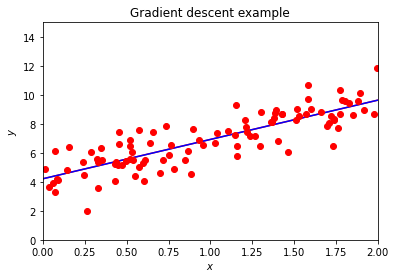

In [21]:

# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# the number of datapoints
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
# Hessian matrix
H = (2.0/n)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
print("Eigenvalues of Hessian Matrix: ", EigValues)

beta_linreg = np.linalg.inv(X.T @ X) @ X.T @ y
print("Matrix inversion:", beta_linreg)
beta = np.random.randn(2,1)

eta = 1.0/np.max(EigValues) # 0.5 --> doesn't converge anymore or 0.0001 and decrese number of itrations, doesnt converge either
Niterations = 1000

for iter in range(Niterations):
    gradient = (2.0/n)*X.T @ (X @ beta-y)
    beta -= eta*gradient

print("Gradient Descent:", beta)
xnew = np.array([[0],[2]])
xbnew = np.c_[np.ones((2,1)), xnew]
ypredict = xbnew.dot(beta)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example')
plt.show()

## And a corresponding example using **scikit-learn**

In [18]:
# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
beta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print(beta_linreg)
sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(x,y.ravel())
print(sgdreg.intercept_, sgdreg.coef_)

[[4.05265693]
 [2.91394133]]
[4.09000858] [2.98637528]


<!-- !split  -->
## Gradient descent and Ridge

We have also discussed Ridge regression where the loss function contains a regularized term given by the $L_2$ norm of $\beta$,

$$
C_{\text{ridge}}(\beta) = \frac{1}{n}||X\beta -\mathbf{y}||^2 + \lambda ||\beta||^2, \ \lambda \geq 0.
$$

In order to minimize $C_{\text{ridge}}(\beta)$ using GD we only have adjust the gradient as follows

$$
\nabla_\beta C_{\text{ridge}}(\beta)  = \frac{2}{n}\begin{bmatrix} \sum_{i=1}^{100} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{100}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{bmatrix} + 2\lambda\begin{bmatrix} \beta_0 \\ \beta_1\end{bmatrix} = 2 (X^T(X\beta - \mathbf{y})+\lambda \beta).
$$

We can easily extend our program to minimize $C_{\text{ridge}}(\beta)$ using gradient descent and compare with the analytical solution given by

$$
\beta_{\text{ridge}} = \left(X^T X + \lambda I_{2 \times 2} \right)^{-1} X^T \mathbf{y}.
$$

## Program example for gradient descent with Ridge Regression

[[3.91024633]
 [3.04451996]]
[[3.82835477]
 [3.11106185]]


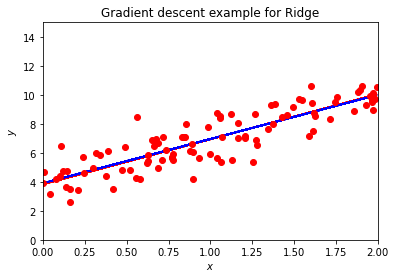

In [19]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# the number of datapoints
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X

#Ridge parameter lambda
lmbda  = 0.001
Id = lmbda* np.eye(XT_X.shape[0])

beta_linreg = np.linalg.inv(XT_X+Id) @ X.T @ y
print(beta_linreg)
# Start plain gradient descent
beta = np.random.randn(2,1)

eta = 0.1
Niterations = 100

for iter in range(Niterations):
    gradients = 2.0/n*X.T @ (X @ (beta)-y)+2*lmbda*beta
    beta -= eta*gradients

print(beta)
ypredict = X @ beta
ypredict2 = X @ beta_linreg
plt.plot(x, ypredict, "r-")
plt.plot(x, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example for Ridge')
plt.show()

## Using gradient descent methods, limitations

* **Gradient descent (GD) finds local minima of our function**. Since the GD algorithm is deterministic, if it converges, it will converge to a local minimum of our cost/loss/risk function. Because in ML we are often dealing with extremely rugged landscapes with many local minima, this can lead to poor performance.

* **GD is sensitive to initial conditions**. One consequence of the local nature of GD is that initial conditions matter. Depending on where one starts, one will end up at a different local minima. Therefore, it is very important to think about how one initializes the training process. This is true for GD as well as more complicated variants of GD.

* **Gradients are computationally expensive to calculate for large datasets**. In many cases in statistics and ML, the cost/loss/risk function is a sum of terms, with one term for each data point. For example, in linear regression, $E \propto \sum_{i=1}^n (y_i - \mathbf{w}^T\cdot\mathbf{x}_i)^2$; for logistic regression, the square error is replaced by the cross entropy. To calculate the gradient we have to sum over *all* $n$ data points. Doing this at every GD step becomes extremely computationally expensive. An ingenious solution to this, is to calculate the gradients using small subsets of the data called "mini batches". This has the added benefit of introducing stochasticity into our algorithm.

* **GD is very sensitive to choices of learning rates**. GD is extremely sensitive to the choice of learning rates. If the learning rate is very small, the training process take an extremely long time. For larger learning rates, GD can diverge and give poor results. Furthermore, depending on what the local landscape looks like, we have to modify the learning rates to ensure convergence. Ideally, we would *adaptively* choose the learning rates to match the landscape.

* **GD treats all directions in parameter space uniformly.** Another major drawback of GD is that unlike Newton's method, the learning rate for GD is the same in all directions in parameter space. For this reason, the maximum learning rate is set by the behavior of the steepest direction and this can significantly slow down training. Ideally, we would like to take large steps in flat directions and small steps in steep directions. Since we are exploring rugged landscapes where curvatures change, this requires us to keep track of not only the gradient but second derivatives. The ideal scenario would be to calculate the Hessian but this proves to be too computationally expensive. 

* GD can take exponential time to escape saddle points, even with random initialization. As we mentioned, GD is extremely sensitive to initial condition since it determines the particular local minimum GD would eventually reach. However, even with a good initialization scheme, through the introduction of randomness, GD can still take exponential time to escape saddle points.

## Friday October  1


## Stochastic Gradient Descent

Stochastic gradient descent (SGD) and variants thereof address some of
the shortcomings of the Gradient descent method discussed above.

The underlying idea of SGD comes from the observation that the cost
function, which we want to minimize, can almost always be written as a
sum over $n$ data points $\{\mathbf{x}_i\}_{i=1}^n$,

$$
C(\mathbf{\beta}) = \sum_{i=1}^n c_i(\mathbf{x}_i,
\mathbf{\beta}).
$$

## Computation of gradients

This in turn means that the gradient can be
computed as a sum over $i$-gradients

$$
\nabla_\beta C(\mathbf{\beta}) = \sum_i^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta}).
$$

Stochasticity/randomness is introduced by only taking the
gradient on a subset of the data called minibatches.  If there are $n$
data points and the size of each minibatch is $M$, there will be $n/M$
minibatches. We denote these minibatches by $B_k$ where
$k=1,\cdots,n/M$.

## SGD example
As an example, suppose we have $10$ data points $(\mathbf{x}_1,\cdots, \mathbf{x}_{10})$ 
and we choose to have $M=5$ minibathces,
then each minibatch contains two data points. In particular we have
$B_1 = (\mathbf{x}_1,\mathbf{x}_2), \cdots, B_5 =
(\mathbf{x}_9,\mathbf{x}_{10})$. Note that if you choose $M=1$ you
have only a single batch with all data points and on the other extreme,
you may choose $M=n$ resulting in a minibatch for each datapoint, i.e
$B_k = \mathbf{x}_k$.

The idea is now to approximate the gradient by replacing the sum over
all data points with a sum over the data points in one the minibatches
picked at random in each gradient descent step

$$
\nabla_{\beta}
C(\mathbf{\beta}) = \sum_{i=1}^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta}) \rightarrow \sum_{i \in B_k}^n \nabla_\beta
c_i(\mathbf{x}_i, \mathbf{\beta}).
$$

## The gradient step

Thus a gradient descent step now looks like

$$
\beta_{j+1} = \beta_j - \gamma_j \sum_{i \in B_k}^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta})
$$

where $k$ is picked at random with equal
probability from $[1,n/M]$. An iteration over the number of
minibathces (n/M) is commonly referred to as an epoch. Thus it is
typical to choose a number of epochs and for each epoch iterate over
the number of minibatches, as exemplified in the code below.

## Simple example code

In [ ]:
import numpy as np 

n = 100 #100 datapoints 
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
n_epochs = 10 #number of epochs

j = 0
for epoch in range(1,n_epochs+1):
    for i in range(m):
        k = np.random.randint(m) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute new suggestion for 
        j += 1

Taking the gradient only on a subset of the data has two important
benefits. 
<font color=purple>
1. First, it **introduces randomness** which decreases the chance that our opmization scheme gets stuck in a **local minima. **
2. Second, if the **size of the minibatches are small** relative to the number of datapoints ($M <  n$), the **computation of the gradient is much cheaper** since we sum over the datapoints in the $k-th$ minibatch and not all $n$ datapoints.</font>

## When do we stop?

*A natural question is when do we stop the search for a new minimum?*

1. One possibility is to compute the **full gradient after a given number of epochs** and check if the **norm of the gradient is smaller than some threshold** and stop if true. 

However, the condition that the gradient is zero is valid also for local minima, so this would only tell us that we are close to a local/global minimum. 

2. However, we could also evaluate the **cost function** at this point, store the result and continue the search. If the test kicks in at a later stage we can **compare the values** of the cost function and keep the $\beta$ that gave the lowest value.

## Slightly different approach

3. Another approach is to let the **step length $\eta_j$ depend on the number of epochs** in such a way that it **becomes very small after a reasonable time** such that we do not move at all.

As an example, let $e = 0,1,2,3,\cdots$ denote the current epoch and let $t_0, t_1 > 0$ be two fixed numbers. Furthermore, let $t = e \cdot m + i$ where $m$ is the number of minibatches and $i=0,\cdots,m-1$. Then the function $$\eta_j(t; t_0, t_1) = \frac{t_0}{t+t_1} $$ goes to zero as the number of epochs gets large. I.e. we start with a step length $\eta_j (0; t_0, t_1) = t_0/t_1$ which decays in *time* $t$.

<font color=forestgreen>**$\rightarrow$ In this way we can fix the number of epochs, compute $\beta$ and
evaluate the cost function at the end. Repeating the computation will
give a different result since the scheme is random by design. Then we
pick the final $\beta$ that gives the lowest value of the cost
function.**</font>

In [1]:
import numpy as np 

def step_length(t,t0,t1):
    return t0/(t+t1)

n = 100 #100 datapoints 
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
n_epochs = 500 #number of epochs
t0 = 1.0
t1 = 10

gamma_j = t0/t1
j = 0
for epoch in range(1,n_epochs+1):
    for i in range(m):
        k = np.random.randint(m) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute new suggestion for beta
        t = epoch*m+i
        gamma_j = step_length(t,t0,t1)
        j += 1

print("gamma_j after %d epochs: %g" % (n_epochs,gamma_j))

gamma_j after 500 epochs: 9.97108e-05


## Program for stochastic gradient

Own inversion:      [4.01172064] [2.99266688]
beta from own gd:   [4.01172064] [2.99266688]
beta from own sdg:  [4.00331435] [2.95372898]
sgdreg from scikit: [4.0119161] [3.03951596]


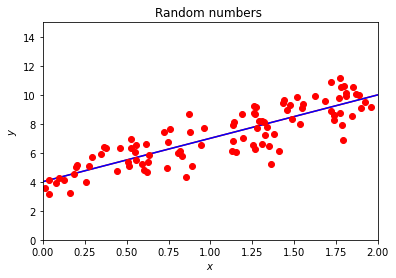

In [5]:
# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

m = 100
x = 2*np.random.rand(m,1)
y = 4+3*x+np.random.randn(m,1)

X = np.c_[np.ones((m,1)), x]

# our own code
beta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:     ", beta_linreg[0], beta_linreg[1])

# our own gradient discent
beta = np.random.randn(2,1)
eta = 0.1
Niterations = 1000

for iter in range(Niterations):
    gradients = 2.0/m*X.T @ ((X @ beta)-y)
    beta -= eta*gradients
print("beta from own gd:  ", beta[0],beta[1])

xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict = Xnew.dot(beta)
ypredict2 = Xnew.dot(beta_linreg)

# our own stochastic gradient descent
n_epochs = 50
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

beta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T @ ((xi @ beta)-yi)
        eta = learning_schedule(epoch*m+i)
        beta = beta - eta*gradients
print("beta from own sdg: ", beta[0],beta[1])

# Sk: stochastic gradient descent
sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(x,y.ravel())
print("sgdreg from scikit:", sgdreg.intercept_,sgdreg.coef_)

plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()

**Challenge**: try to write a similar code for a Logistic Regression case.